In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import joblib

In [2]:
def my_mean_euclidean_distance(y_true, y_pred):
    points = len(y_true)
    tot_sum = 0
    for i in range (points):
        tot_sum += LA.norm(y_true[i] - y_pred[i])
    
    return tot_sum / points

In [3]:
mean_euclidean_distance = make_scorer(my_mean_euclidean_distance, greater_is_better=False)

### Loading data

In [4]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'class1', 'class2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[7:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [5]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

In [7]:
y1_mlcup_tr = y_mlcup_tr[:, 0]
y2_mlcup_tr = y_mlcup_tr[:, 1]

## SVR (first target)

### rbf kernel

In [8]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)

param_grid = dict(
    gamma = gamma_range,
    C = C_range
)

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END ........C=0.25, gamma=0.001953125;, score=-0.119 total time=   0.0s
[CV 2/4] END ........C=0.25, gamma=0.001953125;, score=-0.108 total time=   0.0s
[CV 3/4] END ........C=0.25, gamma=0.001953125;, score=-0.110 total time=   0.0s
[CV 4/4] END ........C=0.25, gamma=0.001953125;, score=-0.112 total time=   0.0s
[CV 1/4] END C=0.25, gamma=0.0049215666011518475;, score=-0.083 total time=   0.0s
[CV 2/4] END C=0.25, gamma=0.0049215666011518475;, score=-0.073 total time=   0.0s
[CV 3/4] END C=0.25, gamma=0.0049215666011518475;, score=-0.076 total time=   0.0s
[CV 4/4] END C=0.25, gamma=0.0049215666011518475;, score=-0.078 total time=   0.0s
[CV 1/4] END C=0.25, gamma=0.012401570718501554;, score=-0.065 total time=   0.0s
[CV 2/4] END C=0.25, gamma=0.012401570718501554;, score=-0.058 total time=   0.0s
[CV 3/4] END C=0.25, gamma=0.012401570718501554;, score=-0.061 total time=   0.0s
[CV 4/4] END C=0.25, gamma=0.01240

[CV 1/4] END C=0.34935328728921067, gamma=0.19842513149602486;, score=-0.049 total time=   0.0s
[CV 2/4] END C=0.34935328728921067, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 3/4] END C=0.34935328728921067, gamma=0.19842513149602486;, score=-0.047 total time=   0.0s
[CV 4/4] END C=0.34935328728921067, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 1/4] END .C=0.34935328728921067, gamma=0.5;, score=-0.044 total time=   0.0s
[CV 2/4] END .C=0.34935328728921067, gamma=0.5;, score=-0.040 total time=   0.0s
[CV 3/4] END .C=0.34935328728921067, gamma=0.5;, score=-0.043 total time=   0.0s
[CV 4/4] END .C=0.34935328728921067, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 1/4] END C=0.34935328728921067, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 2/4] END C=0.34935328728921067, gamma=1.259921049894872;, score=-0.038 total time=   0.0s
[CV 3/4] END C=0.34935328728921067, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 4/4] E

[CV 2/4] END C=0.5771013262929934, gamma=0.001953125;, score=-0.075 total time=   0.0s
[CV 3/4] END C=0.5771013262929934, gamma=0.001953125;, score=-0.077 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.001953125;, score=-0.080 total time=   0.0s
[CV 1/4] END C=0.5771013262929934, gamma=0.0049215666011518475;, score=-0.066 total time=   0.0s
[CV 2/4] END C=0.5771013262929934, gamma=0.0049215666011518475;, score=-0.059 total time=   0.0s
[CV 3/4] END C=0.5771013262929934, gamma=0.0049215666011518475;, score=-0.062 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.0049215666011518475;, score=-0.062 total time=   0.0s
[CV 1/4] END C=0.5771013262929934, gamma=0.012401570718501554;, score=-0.059 total time=   0.0s
[CV 2/4] END C=0.5771013262929934, gamma=0.012401570718501554;, score=-0.053 total time=   0.0s
[CV 3/4] END C=0.5771013262929934, gamma=0.012401570718501554;, score=-0.055 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.012401570718501554;,

[CV 4/4] END C=0.8064489817576824, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=0.19842513149602486;, score=-0.047 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 3/4] END C=0.8064489817576824, gamma=0.19842513149602486;, score=-0.046 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 1/4] END ..C=0.8064489817576824, gamma=0.5;, score=-0.043 total time=   0.0s
[CV 2/4] END ..C=0.8064489817576824, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 3/4] END ..C=0.8064489817576824, gamma=0.5;, score=-0.043 total time=   0.0s
[CV 4/4] END ..C=0.8064489817576824, gamma=0.5;, score=-0.042 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=1.259921049894872;, score=-0.038 total time=   0.0s
[CV 3/4] END C=

[CV 2/4] END C=1.126942411232332, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 3/4] END C=1.126942411232332, gamma=3.174802103936398;, score=-0.043 total time=   0.0s
[CV 4/4] END C=1.126942411232332, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 1/4] END ...C=1.126942411232332, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 2/4] END ...C=1.126942411232332, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 3/4] END ...C=1.126942411232332, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 4/4] END ...C=1.126942411232332, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=0.001953125;, score=-0.068 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=0.001953125;, score=-0.060 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=0.001953125;, score=-0.063 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=0.001953125;, score=-0.063 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=0.00492156660115

[CV 3/4] END C=1.8616111078399704, gamma=0.03125;, score=-0.052 total time=   0.0s
[CV 4/4] END C=1.8616111078399704, gamma=0.03125;, score=-0.051 total time=   0.0s
[CV 1/4] END C=1.8616111078399704, gamma=0.07874506561842956;, score=-0.050 total time=   0.0s
[CV 2/4] END C=1.8616111078399704, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 3/4] END C=1.8616111078399704, gamma=0.07874506561842956;, score=-0.049 total time=   0.0s
[CV 4/4] END C=1.8616111078399704, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 1/4] END C=1.8616111078399704, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 2/4] END C=1.8616111078399704, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 3/4] END C=1.8616111078399704, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END C=1.8616111078399704, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END ..C=1.8616111078399704, gamma=0.5;, score=-0.042 total time= 

[CV 2/4] END C=2.601439840712011, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 3/4] END C=2.601439840712011, gamma=3.174802103936398;, score=-0.043 total time=   0.0s
[CV 4/4] END C=2.601439840712011, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 1/4] END ...C=2.601439840712011, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 2/4] END ...C=2.601439840712011, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 3/4] END ...C=2.601439840712011, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 4/4] END ...C=2.601439840712011, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 1/4] END C=3.075220066519167, gamma=0.001953125;, score=-0.059 total time=   0.0s
[CV 2/4] END C=3.075220066519167, gamma=0.001953125;, score=-0.053 total time=   0.0s
[CV 3/4] END C=3.075220066519167, gamma=0.001953125;, score=-0.056 total time=   0.0s
[CV 4/4] END C=3.075220066519167, gamma=0.001953125;, score=-0.056 total time=   0.0s
[CV 1/4] END C=3.075220066519167, gamma=0.00492156660115

[CV 1/4] END C=4.297352957504864, gamma=0.07874506561842956;, score=-0.048 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 3/4] END C=4.297352957504864, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=0.07874506561842956;, score=-0.046 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 3/4] END C=4.297352957504864, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END ...C=4.297352957504864, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 2/4] END ...C=4.297352957504864, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 3/4] END ...C=4.297352957504864, gamma=0.5;, score=-0.044 total time=   0.0s
[CV 4

[CV 3/4] END C=6.005177529385341, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 4/4] END C=6.005177529385341, gamma=1.259921049894872;, score=-0.040 total time=   0.0s
[CV 1/4] END C=6.005177529385341, gamma=3.174802103936398;, score=-0.045 total time=   0.0s
[CV 2/4] END C=6.005177529385341, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 3/4] END C=6.005177529385341, gamma=3.174802103936398;, score=-0.044 total time=   0.0s
[CV 4/4] END C=6.005177529385341, gamma=3.174802103936398;, score=-0.042 total time=   0.0s
[CV 1/4] END ...C=6.005177529385341, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 2/4] END ...C=6.005177529385341, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 3/4] END ...C=6.005177529385341, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 4/4] END ...C=6.005177529385341, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 1/4] END C=7.098854316124152, gamma=0.001953125;, score=-0.057 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamm

[CV 4/4] END C=9.920032365300699, gamma=0.03125;, score=-0.048 total time=   0.0s
[CV 1/4] END C=9.920032365300699, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 2/4] END C=9.920032365300699, gamma=0.07874506561842956;, score=-0.044 total time=   0.0s
[CV 3/4] END C=9.920032365300699, gamma=0.07874506561842956;, score=-0.047 total time=   0.0s
[CV 4/4] END C=9.920032365300699, gamma=0.07874506561842956;, score=-0.045 total time=   0.0s
[CV 1/4] END C=9.920032365300699, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 2/4] END C=9.920032365300699, gamma=0.19842513149602486;, score=-0.043 total time=   0.0s
[CV 3/4] END C=9.920032365300699, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END C=9.920032365300699, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END ...C=9.920032365300699, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 2/4] END ...C=9.920032365300699, gamma=0.5;, score=-0.042 total time=   0.0s
[CV 

[CV 2/4] END C=13.862383667332647, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 3/4] END C=13.862383667332647, gamma=1.259921049894872;, score=-0.046 total time=   0.0s
[CV 4/4] END C=13.862383667332647, gamma=1.259921049894872;, score=-0.041 total time=   0.0s
[CV 1/4] END C=13.862383667332647, gamma=3.174802103936398;, score=-0.045 total time=   0.0s
[CV 2/4] END C=13.862383667332647, gamma=3.174802103936398;, score=-0.040 total time=   0.0s
[CV 3/4] END C=13.862383667332647, gamma=3.174802103936398;, score=-0.045 total time=   0.0s
[CV 4/4] END C=13.862383667332647, gamma=3.174802103936398;, score=-0.043 total time=   0.0s
[CV 1/4] END ..C=13.862383667332647, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 2/4] END ..C=13.862383667332647, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 3/4] END ..C=13.862383667332647, gamma=8.0;, score=-0.052 total time=   0.0s
[CV 4/4] END ..C=13.862383667332647, gamma=8.0;, score=-0.048 total time=   0.0s
[CV 1/4] END C=16.3870329

[CV 2/4] END C=22.899455339537813, gamma=0.0049215666011518475;, score=-0.051 total time=   0.0s
[CV 3/4] END C=22.899455339537813, gamma=0.0049215666011518475;, score=-0.053 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.0049215666011518475;, score=-0.052 total time=   0.0s
[CV 1/4] END C=22.899455339537813, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 2/4] END C=22.899455339537813, gamma=0.012401570718501554;, score=-0.049 total time=   0.0s
[CV 3/4] END C=22.899455339537813, gamma=0.012401570718501554;, score=-0.052 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.012401570718501554;, score=-0.050 total time=   0.0s
[CV 1/4] END C=22.899455339537813, gamma=0.03125;, score=-0.049 total time=   0.0s
[CV 2/4] END C=22.899455339537813, gamma=0.03125;, score=-0.045 total time=   0.0s
[CV 3/4] END C=22.899455339537813, gamma=0.03125;, score=-0.048 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.03125;, score=-0.047 total time= 

[CV 2/4] END C=32.0, gamma=0.19842513149602486;, score=-0.042 total time=   0.0s
[CV 3/4] END C=32.0, gamma=0.19842513149602486;, score=-0.045 total time=   0.0s
[CV 4/4] END C=32.0, gamma=0.19842513149602486;, score=-0.044 total time=   0.0s
[CV 1/4] END ................C=32.0, gamma=0.5;, score=-0.042 total time=   0.0s
[CV 2/4] END ................C=32.0, gamma=0.5;, score=-0.043 total time=   0.0s
[CV 3/4] END ................C=32.0, gamma=0.5;, score=-0.046 total time=   0.0s
[CV 4/4] END ................C=32.0, gamma=0.5;, score=-0.041 total time=   0.0s
[CV 1/4] END ..C=32.0, gamma=1.259921049894872;, score=-0.044 total time=   0.0s
[CV 2/4] END ..C=32.0, gamma=1.259921049894872;, score=-0.042 total time=   0.0s
[CV 3/4] END ..C=32.0, gamma=1.259921049894872;, score=-0.047 total time=   0.0s
[CV 4/4] END ..C=32.0, gamma=1.259921049894872;, score=-0.043 total time=   0.0s
[CV 1/4] END ..C=32.0, gamma=3.174802103936398;, score=-0.045 total time=   0.0s
[CV 2/4] END ..C=32.0, gamma

In [9]:
rbf_classifier_1 = SVR(
    C = grid.best_params_['C'],
    gamma = grid.best_params_['gamma'],
    kernel = 'rbf'
)
rbf_results_1 = rbf_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

### linear kernel

In [10]:
C_range = np.logspace(-2, 10, 100, base = 2)

param_grid = dict(
    C = C_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4] END ...........................C=0.25;, score=-0.055 total time=   0.0s
[CV 2/4] END ...........................C=0.25;, score=-0.052 total time=   0.0s
[CV 3/4] END ...........................C=0.25;, score=-0.054 total time=   0.0s
[CV 4/4] END ...........................C=0.25;, score=-0.053 total time=   0.0s
[CV 1/4] END ............C=0.27191207433879777;, score=-0.055 total time=   0.0s
[CV 2/4] END ............C=0.27191207433879777;, score=-0.052 total time=   0.0s
[CV 3/4] END ............C=0.27191207433879777;, score=-0.054 total time=   0.0s
[CV 4/4] END ............C=0.27191207433879777;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=0.2957447046849116;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=0.2957447046849116;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=0.2957447046849116;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=0.2957447046849116

[CV 4/4] END ..............C=2.042453212630728;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=2.2214707591454514;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=2.2214707591454514;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=2.2214707591454514;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=2.2214707591454514;, score=-0.053 total time=   0.0s
[CV 1/4] END ..............C=2.416178888808895;, score=-0.055 total time=   0.0s
[CV 2/4] END ..............C=2.416178888808895;, score=-0.052 total time=   0.0s
[CV 3/4] END ..............C=2.416178888808895;, score=-0.054 total time=   0.0s
[CV 4/4] END ..............C=2.416178888808895;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=2.6279528545185524;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=2.6279528545185524;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=2.6279528545185524;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=

[CV 1/4] END .............C=19.739729334953076;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=19.739729334953076;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=19.739729334953076;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=19.739729334953076;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=21.469883001414043;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=21.469883001414043;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=21.469883001414043;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=21.469883001414043;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=23.351681690903145;, score=-0.055 total time=   0.0s
[CV 2/4] END .............C=23.351681690903145;, score=-0.052 total time=   0.0s
[CV 3/4] END .............C=23.351681690903145;, score=-0.054 total time=   0.0s
[CV 4/4] END .............C=23.351681690903145;, score=-0.053 total time=   0.0s
[CV 1/4] END .............C=

[CV 4/4] END .............C=161.26989438654383;, score=-0.053 total time=   0.1s
[CV 1/4] END .............C=175.40492604417588;, score=-0.055 total time=   0.1s
[CV 2/4] END .............C=175.40492604417588;, score=-0.052 total time=   0.1s
[CV 3/4] END .............C=175.40492604417588;, score=-0.054 total time=   0.1s
[CV 4/4] END .............C=175.40492604417588;, score=-0.053 total time=   0.1s
[CV 1/4] END .............C=190.77886915966113;, score=-0.055 total time=   0.1s
[CV 2/4] END .............C=190.77886915966113;, score=-0.052 total time=   0.1s
[CV 3/4] END .............C=190.77886915966113;, score=-0.054 total time=   0.1s
[CV 4/4] END .............C=190.77886915966113;, score=-0.053 total time=   0.1s
[CV 1/4] END ..............C=207.5003122128542;, score=-0.055 total time=   0.1s
[CV 2/4] END ..............C=207.5003122128542;, score=-0.052 total time=   0.1s
[CV 3/4] END ..............C=207.5003122128542;, score=-0.054 total time=   0.1s
[CV 4/4] END ..............C

In [11]:
linear_classifier_1 = SVR(
    C = grid.best_params_['C'],
    kernel = 'linear'
)
linear_results_1 = linear_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

### polynomial kernel

In [12]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)

param_grid = dict(
    degree = degree_range,
    C = C_range,
    gamma = gamma_range
)

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.246 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.248 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.246 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.248 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=2, gamma=0.009113508121688412;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.009113508121688412;, score=-0.245 total

[CV 1/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.246 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.248 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.246 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.248 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=4, gamma=0.042524687505449285;, score=-0.251 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=4, gamma=0.042524687505449285;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.0

[CV 2/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.245 total time=   0.0s
[CV 3/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.246 total time=   0.0s
[CV 4/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.248 total time=   0.0s
[CV 1/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.249 total time=   0.0s
[CV 2/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.243 total time=   0.0s
[CV 3/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.245 total time=   0.0s
[CV 4/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.246 total time=   0.0s
[CV 1/4] END C=0.005741150360451557, degree=3, gamma=0.09185840576722491;, score=-0.234 total time=   0.0s
[CV 2/4] END C=0.005741150360451557, degree=3, gamma=0.09185840576722491;, score=-0.228 total time=   0.0s
[CV 3/4] END C=0.005741150360451557,

[CV 2/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.212 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.214 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.215 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=2, gamma=0.09185840576722491;, score=-0.145 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=2, gamma=0.09185840576722491;, score=-0.133 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=2, gamma=0.09185840576722491;, score=-0.136 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=2, gamma=0.09185840576722491;, score=-0.137 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=2, gamma=0.19842513149602498;, score=-0.083 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=2, gamma=0.19842513149602498;, score=-0.073 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=

[CV 1/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.237 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.231 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.232 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.234 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=4, gamma=0.19842513149602498;, score=-0.122 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=4, gamma=0.19842513149602498;, score=-0.112 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=4, gamma=0.19842513149602498;, score=-0.115 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=4, gamma=0.19842513149602498;, score=-0.115 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=4, gamma=0.4286219914265367;, score=-0.080 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=4, g

[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.042524687505449285;, score=-0.234 total time=   0.0s
[CV 1/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.153 total time=   0.0s
[CV 2/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.141 total time=   0.0s
[CV 3/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.145 total time=   0.0s
[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.145 total time=   0.0s
[CV 1/4] END C=0.049606282874006244, degree=3, gamma=0.19842513149602498;, score=-0.081 total time=   0.0s
[CV 2/4] END C=0.049606282874006244, degree=3, gamma=0.19842513149602498;, score=-0.075 total time=   0.0s
[CV 3/4] END C=0.049606282874006244, degree=3, gamma=0.19842513149602498;, score=-0.076 total time=   0.0s
[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.19842513149602498;, score=-0.078 total time=   0.0s
[CV 1/4] END C=0.049606282874006244,

[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.073 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.066 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.069 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0.19842513149602498;, score=-0.062 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=2, gamma=0.19842513149602498;, score=-0.058 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=2, gamma=0.19842513149602498;, score=-0.059 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=2, gamma=0.19842513149602498;, score=-0.061 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0.4286219914265367;, score=-0.057 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=2, gamma=0.428

[CV 2/4] END C=0.1458161299470146, degree=4, gamma=0.09185840576722491;, score=-0.154 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.09185840576722491;, score=-0.158 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=4, gamma=0.09185840576722491;, score=-0.158 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.086 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.080 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.080 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.083 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=4, gamma=0.4286219914265367;, score=-0.072 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=4, gamma=0.4286219914265367;, score=-0.067 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.4286

[CV 2/4] END C=0.4286219914265364, degree=3, gamma=0.09185840576722491;, score=-0.076 total time=   0.0s
[CV 3/4] END C=0.4286219914265364, degree=3, gamma=0.09185840576722491;, score=-0.078 total time=   0.0s
[CV 4/4] END C=0.4286219914265364, degree=3, gamma=0.09185840576722491;, score=-0.079 total time=   0.0s
[CV 1/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.068 total time=   0.0s
[CV 2/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.063 total time=   0.0s
[CV 3/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.063 total time=   0.0s
[CV 4/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.065 total time=   0.0s
[CV 1/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.062 total time=   0.0s
[CV 2/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.058 total time=   0.0s
[CV 3/4] END C=0.4286219914265364, degree=3, gamma=0.4286

[CV 1/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.054 total time=   0.0s
[CV 2/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.050 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.053 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.054 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.052 total time=   0.0s
[CV 2/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.050 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.053 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.053 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=2, gamma=2.0;, score=-0.053 total time=   0.0s
[CV 2/4] END C=1.2599210498948736, degree=2, gamma=2.0;, score=-0.052 total tim

[CV 2/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.065 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.064 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.066 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.067 total time=   0.3s
[CV 2/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.062 total time=   0.2s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.064 total time=   0.2s
[CV 4/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.067 total time=   0.2s
[CV 1/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.070 total time=   7.2s
[CV 2/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.069 total time=   7.2s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.070 total time=   7.9s
[CV 4

[CV 1/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.060 total time=   0.1s
[CV 2/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.057 total time=   0.1s
[CV 3/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.058 total time=   0.1s
[CV 4/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.060 total time=   0.1s
[CV 1/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.060 total time=   1.3s
[CV 2/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.058 total time=   1.8s
[CV 3/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.059 total time=   1.5s
[CV 4/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.061 total time=   1.7s
[CV 1/4] END C=3.7034988491491627, degree=4, gamma=0.001953125;, score=-0.251 total time=   0.0s
[CV 2/4] END C=3.7034988491491627, degree=4, gamma=0.001953125;, score=-0.245 total time=   0.0s
[CV 3/4] END C=3.7034988491491627,

[CV 1/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.053 total time=   0.1s
[CV 2/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.052 total time=   0.1s
[CV 3/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.053 total time=   0.1s
[CV 4/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.053 total time=   0.1s
[CV 1/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.053 total time=   0.3s
[CV 2/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.053 total time=   0.3s
[CV 3/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.054 total time=   0.2s
[CV 4/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.053 total time=   0.4s
[CV 1/4] END C=10.886320001395017, degree=3, gamma=0.001953125;, score=-0.250 total time=   0.0s
[CV 2/4] END C=10.886320001395017, degree=3, gamma=0.001953125;, score=-0.245 total time=   0.0s
[CV 3/4] END C=10.886320001395017,

[CV 1/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.068 total time=   2.2s
[CV 2/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.066 total time=   2.3s
[CV 3/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.068 total time=   2.4s
[CV 4/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.070 total time=   2.3s
[CV 1/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.076 total time=  49.9s
[CV 2/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.074 total time=  59.9s
[CV 3/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.074 total time= 1.6min
[CV 4/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.075 total time= 1.5min
[CV 1/4] END C=32.0, degree=2, gamma=0.001953125;, score=-0.153 total time=   0.0s
[CV 2/4] END C=32.0, degree=2, gamma=0.001953125;, score=-0.141 total time=   0.0s
[CV 3/4] END C=32.0, degree=2, gamma=0.001953125;, score=-0.14

[CV 2/4] END C=32.0, degree=4, gamma=0.00421898335504807;, score=-0.245 total time=   0.0s
[CV 3/4] END C=32.0, degree=4, gamma=0.00421898335504807;, score=-0.246 total time=   0.0s
[CV 4/4] END C=32.0, degree=4, gamma=0.00421898335504807;, score=-0.248 total time=   0.0s
[CV 1/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.248 total time=   0.0s
[CV 2/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.242 total time=   0.0s
[CV 3/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.244 total time=   0.0s
[CV 4/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.245 total time=   0.0s
[CV 1/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.201 total time=   0.0s
[CV 2/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.192 total time=   0.0s
[CV 3/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.195 total time=   0.0s
[CV 4/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.196 total time=   0.0s

In [15]:
poly_classifier_1 = SVR(
    C = grid.best_params_['C'],
    gamma = grid.best_params_['gamma'],
    degree = grid.best_params_['degree'],
    kernel = 'poly'
)
poly_results_1 = poly_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

## SVR (second target)

### rbf kernel

In [16]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 30, base = 2)

param_grid = dict(
    gamma = gamma_range,
    C = C_range
)

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 900 candidates, totalling 3600 fits
[CV 1/4] END ........C=0.25, gamma=0.001953125;, score=-0.127 total time=   0.0s
[CV 2/4] END ........C=0.25, gamma=0.001953125;, score=-0.135 total time=   0.0s
[CV 3/4] END ........C=0.25, gamma=0.001953125;, score=-0.127 total time=   0.0s
[CV 4/4] END ........C=0.25, gamma=0.001953125;, score=-0.133 total time=   0.0s
[CV 1/4] END C=0.25, gamma=0.002601921412571344;, score=-0.122 total time=   0.0s
[CV 2/4] END C=0.25, gamma=0.002601921412571344;, score=-0.129 total time=   0.0s
[CV 3/4] END C=0.25, gamma=0.002601921412571344;, score=-0.122 total time=   0.0s
[CV 4/4] END C=0.25, gamma=0.002601921412571344;, score=-0.127 total time=   0.0s
[CV 1/4] END C=0.25, gamma=0.003466237459044996;, score=-0.117 total time=   0.0s
[CV 2/4] END C=0.25, gamma=0.003466237459044996;, score=-0.123 total time=   0.0s
[CV 3/4] END C=0.25, gamma=0.003466237459044996;, score=-0.116 total time=   0.0s
[CV 4/4] END C=0.25, gamma=0.003466237

[CV 4/4] END .C=0.25, gamma=3.3837446224218675;, score=-0.062 total time=   0.0s
[CV 1/4] END ..C=0.25, gamma=4.507769644929328;, score=-0.068 total time=   0.0s
[CV 2/4] END ..C=0.25, gamma=4.507769644929328;, score=-0.067 total time=   0.0s
[CV 3/4] END ..C=0.25, gamma=4.507769644929328;, score=-0.067 total time=   0.0s
[CV 4/4] END ..C=0.25, gamma=4.507769644929328;, score=-0.062 total time=   0.0s
[CV 1/4] END ..C=0.25, gamma=6.005177529385341;, score=-0.067 total time=   0.0s
[CV 2/4] END ..C=0.25, gamma=6.005177529385341;, score=-0.068 total time=   0.0s
[CV 3/4] END ..C=0.25, gamma=6.005177529385341;, score=-0.067 total time=   0.0s
[CV 4/4] END ..C=0.25, gamma=6.005177529385341;, score=-0.063 total time=   0.0s
[CV 1/4] END ................C=0.25, gamma=8.0;, score=-0.068 total time=   0.0s
[CV 2/4] END ................C=0.25, gamma=8.0;, score=-0.069 total time=   0.0s
[CV 3/4] END ................C=0.25, gamma=8.0;, score=-0.067 total time=   0.0s
[CV 4/4] END ...............

[CV 3/4] END C=0.295530576797567, gamma=0.6053586629808656;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.295530576797567, gamma=0.6053586629808656;, score=-0.067 total time=   0.0s
[CV 1/4] END C=0.295530576797567, gamma=0.8064489817576826;, score=-0.072 total time=   0.0s
[CV 2/4] END C=0.295530576797567, gamma=0.8064489817576826;, score=-0.068 total time=   0.0s
[CV 3/4] END C=0.295530576797567, gamma=0.8064489817576826;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.295530576797567, gamma=0.8064489817576826;, score=-0.066 total time=   0.0s
[CV 1/4] END C=0.295530576797567, gamma=1.074338239376216;, score=-0.071 total time=   0.0s
[CV 2/4] END C=0.295530576797567, gamma=1.074338239376216;, score=-0.067 total time=   0.0s
[CV 3/4] END C=0.295530576797567, gamma=1.074338239376216;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.295530576797567, gamma=1.074338239376216;, score=-0.066 total time=   0.0s
[CV 1/4] END C=0.295530576797567, gamma=1.4312159587211133;, score=-0.071 

[CV 4/4] END C=0.34935328728921067, gamma=0.08129499502225035;, score=-0.075 total time=   0.0s
[CV 1/4] END C=0.34935328728921067, gamma=0.1082998724010363;, score=-0.076 total time=   0.0s
[CV 2/4] END C=0.34935328728921067, gamma=0.1082998724010363;, score=-0.074 total time=   0.0s
[CV 3/4] END C=0.34935328728921067, gamma=0.1082998724010363;, score=-0.075 total time=   0.0s
[CV 4/4] END C=0.34935328728921067, gamma=0.1082998724010363;, score=-0.073 total time=   0.0s
[CV 1/4] END C=0.34935328728921067, gamma=0.14427533157324834;, score=-0.074 total time=   0.0s
[CV 2/4] END C=0.34935328728921067, gamma=0.14427533157324834;, score=-0.072 total time=   0.0s
[CV 3/4] END C=0.34935328728921067, gamma=0.14427533157324834;, score=-0.074 total time=   0.0s
[CV 4/4] END C=0.34935328728921067, gamma=0.14427533157324834;, score=-0.071 total time=   0.0s
[CV 1/4] END C=0.34935328728921067, gamma=0.19220125415744788;, score=-0.073 total time=   0.0s
[CV 2/4] END C=0.34935328728921067, gamma=0.

[CV 2/4] END C=0.41297831399482615, gamma=0.01091729022778783;, score=-0.090 total time=   0.0s
[CV 3/4] END C=0.41297831399482615, gamma=0.01091729022778783;, score=-0.087 total time=   0.0s
[CV 4/4] END C=0.41297831399482615, gamma=0.01091729022778783;, score=-0.091 total time=   0.0s
[CV 1/4] END C=0.41297831399482615, gamma=0.014543836779999764;, score=-0.088 total time=   0.0s
[CV 2/4] END C=0.41297831399482615, gamma=0.014543836779999764;, score=-0.086 total time=   0.0s
[CV 3/4] END C=0.41297831399482615, gamma=0.014543836779999764;, score=-0.084 total time=   0.0s
[CV 4/4] END C=0.41297831399482615, gamma=0.014543836779999764;, score=-0.087 total time=   0.0s
[CV 1/4] END C=0.41297831399482615, gamma=0.019375063213477914;, score=-0.086 total time=   0.0s
[CV 2/4] END C=0.41297831399482615, gamma=0.019375063213477914;, score=-0.083 total time=   0.0s
[CV 3/4] END C=0.41297831399482615, gamma=0.019375063213477914;, score=-0.083 total time=   0.0s
[CV 4/4] END C=0.4129783139948261

[CV 4/4] END C=0.41297831399482615, gamma=6.005177529385341;, score=-0.062 total time=   0.0s
[CV 1/4] END .C=0.41297831399482615, gamma=8.0;, score=-0.068 total time=   0.0s
[CV 2/4] END .C=0.41297831399482615, gamma=8.0;, score=-0.070 total time=   0.0s
[CV 3/4] END .C=0.41297831399482615, gamma=8.0;, score=-0.067 total time=   0.0s
[CV 4/4] END .C=0.41297831399482615, gamma=8.0;, score=-0.065 total time=   0.0s
[CV 1/4] END C=0.488190877359111, gamma=0.001953125;, score=-0.115 total time=   0.0s
[CV 2/4] END C=0.488190877359111, gamma=0.001953125;, score=-0.121 total time=   0.0s
[CV 3/4] END C=0.488190877359111, gamma=0.001953125;, score=-0.114 total time=   0.0s
[CV 4/4] END C=0.488190877359111, gamma=0.001953125;, score=-0.119 total time=   0.0s
[CV 1/4] END C=0.488190877359111, gamma=0.002601921412571344;, score=-0.111 total time=   0.0s
[CV 2/4] END C=0.488190877359111, gamma=0.002601921412571344;, score=-0.115 total time=   0.0s
[CV 3/4] END C=0.488190877359111, gamma=0.002601

[CV 4/4] END C=0.488190877359111, gamma=0.8064489817576826;, score=-0.066 total time=   0.0s
[CV 1/4] END C=0.488190877359111, gamma=1.074338239376216;, score=-0.071 total time=   0.0s
[CV 2/4] END C=0.488190877359111, gamma=1.074338239376216;, score=-0.067 total time=   0.0s
[CV 3/4] END C=0.488190877359111, gamma=1.074338239376216;, score=-0.069 total time=   0.0s
[CV 4/4] END C=0.488190877359111, gamma=1.074338239376216;, score=-0.066 total time=   0.0s
[CV 1/4] END C=0.488190877359111, gamma=1.4312159587211133;, score=-0.071 total time=   0.0s
[CV 2/4] END C=0.488190877359111, gamma=1.4312159587211133;, score=-0.067 total time=   0.0s
[CV 3/4] END C=0.488190877359111, gamma=1.4312159587211133;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.488190877359111, gamma=1.4312159587211133;, score=-0.066 total time=   0.0s
[CV 1/4] END C=0.488190877359111, gamma=1.9066426618932684;, score=-0.071 total time=   0.0s
[CV 2/4] END C=0.488190877359111, gamma=1.9066426618932684;, score=-0.067 

[CV 3/4] END C=0.5771013262929934, gamma=0.14427533157324834;, score=-0.073 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.14427533157324834;, score=-0.070 total time=   0.0s
[CV 1/4] END C=0.5771013262929934, gamma=0.19220125415744788;, score=-0.073 total time=   0.0s
[CV 2/4] END C=0.5771013262929934, gamma=0.19220125415744788;, score=-0.072 total time=   0.0s
[CV 3/4] END C=0.5771013262929934, gamma=0.19220125415744788;, score=-0.070 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.19220125415744788;, score=-0.069 total time=   0.0s
[CV 1/4] END C=0.5771013262929934, gamma=0.2560473900622493;, score=-0.073 total time=   0.0s
[CV 2/4] END C=0.5771013262929934, gamma=0.2560473900622493;, score=-0.071 total time=   0.0s
[CV 3/4] END C=0.5771013262929934, gamma=0.2560473900622493;, score=-0.069 total time=   0.0s
[CV 4/4] END C=0.5771013262929934, gamma=0.2560473900622493;, score=-0.069 total time=   0.0s
[CV 1/4] END C=0.5771013262929934, gamma=0.34110217566

[CV 1/4] END C=0.6822043513200371, gamma=0.025811144624676628;, score=-0.082 total time=   0.0s
[CV 2/4] END C=0.6822043513200371, gamma=0.025811144624676628;, score=-0.079 total time=   0.0s
[CV 3/4] END C=0.6822043513200371, gamma=0.025811144624676628;, score=-0.081 total time=   0.0s
[CV 4/4] END C=0.6822043513200371, gamma=0.025811144624676628;, score=-0.079 total time=   0.0s
[CV 1/4] END C=0.6822043513200371, gamma=0.03438518777954402;, score=-0.081 total time=   0.0s
[CV 2/4] END C=0.6822043513200371, gamma=0.03438518777954402;, score=-0.078 total time=   0.0s
[CV 3/4] END C=0.6822043513200371, gamma=0.03438518777954402;, score=-0.080 total time=   0.0s
[CV 4/4] END C=0.6822043513200371, gamma=0.03438518777954402;, score=-0.077 total time=   0.0s
[CV 1/4] END C=0.6822043513200371, gamma=0.04580738885574762;, score=-0.079 total time=   0.0s
[CV 2/4] END C=0.6822043513200371, gamma=0.04580738885574762;, score=-0.077 total time=   0.0s
[CV 3/4] END C=0.6822043513200371, gamma=0.045

[CV 3/4] END C=0.8064489817576824, gamma=0.003466237459044996;, score=-0.094 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=0.003466237459044996;, score=-0.098 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=0.004617665262461984;, score=-0.094 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=0.004617665262461984;, score=-0.093 total time=   0.0s
[CV 3/4] END C=0.8064489817576824, gamma=0.004617665262461984;, score=-0.089 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=0.004617665262461984;, score=-0.094 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=0.006151578686713196;, score=-0.090 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=0.006151578686713196;, score=-0.089 total time=   0.0s
[CV 3/4] END C=0.8064489817576824, gamma=0.006151578686713196;, score=-0.087 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=0.006151578686713196;, score=-0.089 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma

[CV 4/4] END C=0.8064489817576824, gamma=1.9066426618932684;, score=-0.064 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=2.5399983964682855;, score=-0.071 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=2.5399983964682855;, score=-0.069 total time=   0.0s
[CV 3/4] END C=0.8064489817576824, gamma=2.5399983964682855;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=2.5399983964682855;, score=-0.062 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=3.3837446224218675;, score=-0.070 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=3.3837446224218675;, score=-0.069 total time=   0.0s
[CV 3/4] END C=0.8064489817576824, gamma=3.3837446224218675;, score=-0.067 total time=   0.0s
[CV 4/4] END C=0.8064489817576824, gamma=3.3837446224218675;, score=-0.062 total time=   0.0s
[CV 1/4] END C=0.8064489817576824, gamma=4.507769644929328;, score=-0.069 total time=   0.0s
[CV 2/4] END C=0.8064489817576824, gamma=4.507769644929328;, 

[CV 2/4] END C=0.953321330946634, gamma=0.2560473900622493;, score=-0.071 total time=   0.0s
[CV 3/4] END C=0.953321330946634, gamma=0.2560473900622493;, score=-0.070 total time=   0.0s
[CV 4/4] END C=0.953321330946634, gamma=0.2560473900622493;, score=-0.068 total time=   0.0s
[CV 1/4] END C=0.953321330946634, gamma=0.3411021756600185;, score=-0.072 total time=   0.0s
[CV 2/4] END C=0.953321330946634, gamma=0.3411021756600185;, score=-0.070 total time=   0.0s
[CV 3/4] END C=0.953321330946634, gamma=0.3411021756600185;, score=-0.069 total time=   0.0s
[CV 4/4] END C=0.953321330946634, gamma=0.3411021756600185;, score=-0.068 total time=   0.0s
[CV 1/4] END C=0.953321330946634, gamma=0.4544107800189307;, score=-0.072 total time=   0.0s
[CV 2/4] END C=0.953321330946634, gamma=0.4544107800189307;, score=-0.069 total time=   0.0s
[CV 3/4] END C=0.953321330946634, gamma=0.4544107800189307;, score=-0.068 total time=   0.0s
[CV 4/4] END C=0.953321330946634, gamma=0.4544107800189307;, score=-0.

[CV 4/4] END C=1.126942411232332, gamma=0.025811144624676628;, score=-0.077 total time=   0.0s
[CV 1/4] END C=1.126942411232332, gamma=0.03438518777954402;, score=-0.080 total time=   0.0s
[CV 2/4] END C=1.126942411232332, gamma=0.03438518777954402;, score=-0.077 total time=   0.0s
[CV 3/4] END C=1.126942411232332, gamma=0.03438518777954402;, score=-0.080 total time=   0.0s
[CV 4/4] END C=1.126942411232332, gamma=0.03438518777954402;, score=-0.076 total time=   0.0s
[CV 1/4] END C=1.126942411232332, gamma=0.04580738885574762;, score=-0.078 total time=   0.0s
[CV 2/4] END C=1.126942411232332, gamma=0.04580738885574762;, score=-0.076 total time=   0.0s
[CV 3/4] END C=1.126942411232332, gamma=0.04580738885574762;, score=-0.078 total time=   0.0s
[CV 4/4] END C=1.126942411232332, gamma=0.04580738885574762;, score=-0.075 total time=   0.0s
[CV 1/4] END C=1.126942411232332, gamma=0.06102385966988887;, score=-0.076 total time=   0.0s
[CV 2/4] END C=1.126942411232332, gamma=0.06102385966988887

[CV 4/4] END C=1.332183763236528, gamma=0.004617665262461984;, score=-0.086 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=0.006151578686713196;, score=-0.086 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=0.006151578686713196;, score=-0.083 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=0.006151578686713196;, score=-0.083 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=0.006151578686713196;, score=-0.084 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=0.008195033244711205;, score=-0.084 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=0.008195033244711205;, score=-0.081 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=0.008195033244711205;, score=-0.082 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=0.008195033244711205;, score=-0.082 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=0.01091729022778783;, score=-0.083 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=0.010917290

[CV 2/4] END C=1.332183763236528, gamma=3.3837446224218675;, score=-0.069 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=3.3837446224218675;, score=-0.067 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=3.3837446224218675;, score=-0.063 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=4.507769644929328;, score=-0.070 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=4.507769644929328;, score=-0.070 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=4.507769644929328;, score=-0.067 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=4.507769644929328;, score=-0.062 total time=   0.0s
[CV 1/4] END C=1.332183763236528, gamma=6.005177529385341;, score=-0.070 total time=   0.0s
[CV 2/4] END C=1.332183763236528, gamma=6.005177529385341;, score=-0.071 total time=   0.0s
[CV 3/4] END C=1.332183763236528, gamma=6.005177529385341;, score=-0.067 total time=   0.0s
[CV 4/4] END C=1.332183763236528, gamma=6.005177529385341;, score=-0.064 tota

[CV 1/4] END C=1.5748041437985787, gamma=0.4544107800189307;, score=-0.072 total time=   0.0s
[CV 2/4] END C=1.5748041437985787, gamma=0.4544107800189307;, score=-0.069 total time=   0.0s
[CV 3/4] END C=1.5748041437985787, gamma=0.4544107800189307;, score=-0.069 total time=   0.0s
[CV 4/4] END C=1.5748041437985787, gamma=0.4544107800189307;, score=-0.067 total time=   0.0s
[CV 1/4] END C=1.5748041437985787, gamma=0.6053586629808656;, score=-0.071 total time=   0.0s
[CV 2/4] END C=1.5748041437985787, gamma=0.6053586629808656;, score=-0.068 total time=   0.0s
[CV 3/4] END C=1.5748041437985787, gamma=0.6053586629808656;, score=-0.068 total time=   0.0s
[CV 4/4] END C=1.5748041437985787, gamma=0.6053586629808656;, score=-0.066 total time=   0.0s
[CV 1/4] END C=1.5748041437985787, gamma=0.8064489817576826;, score=-0.071 total time=   0.0s
[CV 2/4] END C=1.5748041437985787, gamma=0.8064489817576826;, score=-0.067 total time=   0.0s
[CV 3/4] END C=1.5748041437985787, gamma=0.8064489817576826;

[CV 1/4] END C=1.8616111078399704, gamma=0.04580738885574762;, score=-0.076 total time=   0.0s
[CV 2/4] END C=1.8616111078399704, gamma=0.04580738885574762;, score=-0.075 total time=   0.0s
[CV 3/4] END C=1.8616111078399704, gamma=0.04580738885574762;, score=-0.077 total time=   0.0s
[CV 4/4] END C=1.8616111078399704, gamma=0.04580738885574762;, score=-0.073 total time=   0.0s
[CV 1/4] END C=1.8616111078399704, gamma=0.06102385966988887;, score=-0.075 total time=   0.0s
[CV 2/4] END C=1.8616111078399704, gamma=0.06102385966988887;, score=-0.074 total time=   0.0s
[CV 3/4] END C=1.8616111078399704, gamma=0.06102385966988887;, score=-0.075 total time=   0.0s
[CV 4/4] END C=1.8616111078399704, gamma=0.06102385966988887;, score=-0.072 total time=   0.0s
[CV 1/4] END C=1.8616111078399704, gamma=0.08129499502225035;, score=-0.074 total time=   0.0s
[CV 2/4] END C=1.8616111078399704, gamma=0.08129499502225035;, score=-0.073 total time=   0.0s
[CV 3/4] END C=1.8616111078399704, gamma=0.0812949

[CV 3/4] END C=2.200652017890817, gamma=0.004617665262461984;, score=-0.083 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=0.004617665262461984;, score=-0.082 total time=   0.0s
[CV 1/4] END C=2.200652017890817, gamma=0.006151578686713196;, score=-0.083 total time=   0.0s
[CV 2/4] END C=2.200652017890817, gamma=0.006151578686713196;, score=-0.080 total time=   0.0s
[CV 3/4] END C=2.200652017890817, gamma=0.006151578686713196;, score=-0.082 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=0.006151578686713196;, score=-0.081 total time=   0.0s
[CV 1/4] END C=2.200652017890817, gamma=0.008195033244711205;, score=-0.083 total time=   0.0s
[CV 2/4] END C=2.200652017890817, gamma=0.008195033244711205;, score=-0.079 total time=   0.0s
[CV 3/4] END C=2.200652017890817, gamma=0.008195033244711205;, score=-0.082 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=0.008195033244711205;, score=-0.080 total time=   0.0s
[CV 1/4] END C=2.200652017890817, gamma=0.01091729

[CV 2/4] END C=2.200652017890817, gamma=3.3837446224218675;, score=-0.070 total time=   0.0s
[CV 3/4] END C=2.200652017890817, gamma=3.3837446224218675;, score=-0.068 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=3.3837446224218675;, score=-0.063 total time=   0.0s
[CV 1/4] END C=2.200652017890817, gamma=4.507769644929328;, score=-0.071 total time=   0.0s
[CV 2/4] END C=2.200652017890817, gamma=4.507769644929328;, score=-0.071 total time=   0.0s
[CV 3/4] END C=2.200652017890817, gamma=4.507769644929328;, score=-0.067 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=4.507769644929328;, score=-0.063 total time=   0.0s
[CV 1/4] END C=2.200652017890817, gamma=6.005177529385341;, score=-0.071 total time=   0.0s
[CV 2/4] END C=2.200652017890817, gamma=6.005177529385341;, score=-0.073 total time=   0.0s
[CV 3/4] END C=2.200652017890817, gamma=6.005177529385341;, score=-0.068 total time=   0.0s
[CV 4/4] END C=2.200652017890817, gamma=6.005177529385341;, score=-0.066 tota

[CV 1/4] END C=2.601439840712011, gamma=0.4544107800189307;, score=-0.071 total time=   0.0s
[CV 2/4] END C=2.601439840712011, gamma=0.4544107800189307;, score=-0.068 total time=   0.0s
[CV 3/4] END C=2.601439840712011, gamma=0.4544107800189307;, score=-0.069 total time=   0.0s
[CV 4/4] END C=2.601439840712011, gamma=0.4544107800189307;, score=-0.067 total time=   0.0s
[CV 1/4] END C=2.601439840712011, gamma=0.6053586629808656;, score=-0.071 total time=   0.0s
[CV 2/4] END C=2.601439840712011, gamma=0.6053586629808656;, score=-0.067 total time=   0.0s
[CV 3/4] END C=2.601439840712011, gamma=0.6053586629808656;, score=-0.069 total time=   0.0s
[CV 4/4] END C=2.601439840712011, gamma=0.6053586629808656;, score=-0.066 total time=   0.0s
[CV 1/4] END C=2.601439840712011, gamma=0.8064489817576826;, score=-0.071 total time=   0.0s
[CV 2/4] END C=2.601439840712011, gamma=0.8064489817576826;, score=-0.068 total time=   0.0s
[CV 3/4] END C=2.601439840712011, gamma=0.8064489817576826;, score=-0.

[CV 3/4] END C=3.075220066519167, gamma=0.06102385966988887;, score=-0.074 total time=   0.0s
[CV 4/4] END C=3.075220066519167, gamma=0.06102385966988887;, score=-0.070 total time=   0.0s
[CV 1/4] END C=3.075220066519167, gamma=0.08129499502225035;, score=-0.073 total time=   0.0s
[CV 2/4] END C=3.075220066519167, gamma=0.08129499502225035;, score=-0.072 total time=   0.0s
[CV 3/4] END C=3.075220066519167, gamma=0.08129499502225035;, score=-0.071 total time=   0.0s
[CV 4/4] END C=3.075220066519167, gamma=0.08129499502225035;, score=-0.069 total time=   0.0s
[CV 1/4] END C=3.075220066519167, gamma=0.1082998724010363;, score=-0.074 total time=   0.0s
[CV 2/4] END C=3.075220066519167, gamma=0.1082998724010363;, score=-0.072 total time=   0.0s
[CV 3/4] END C=3.075220066519167, gamma=0.1082998724010363;, score=-0.070 total time=   0.0s
[CV 4/4] END C=3.075220066519167, gamma=0.1082998724010363;, score=-0.068 total time=   0.0s
[CV 1/4] END C=3.075220066519167, gamma=0.14427533157324834;, sc

[CV 2/4] END C=3.6352862401514465, gamma=0.01091729022778783;, score=-0.078 total time=   0.0s
[CV 3/4] END C=3.6352862401514465, gamma=0.01091729022778783;, score=-0.082 total time=   0.0s
[CV 4/4] END C=3.6352862401514465, gamma=0.01091729022778783;, score=-0.078 total time=   0.0s
[CV 1/4] END C=3.6352862401514465, gamma=0.014543836779999764;, score=-0.081 total time=   0.0s
[CV 2/4] END C=3.6352862401514465, gamma=0.014543836779999764;, score=-0.078 total time=   0.0s
[CV 3/4] END C=3.6352862401514465, gamma=0.014543836779999764;, score=-0.081 total time=   0.0s
[CV 4/4] END C=3.6352862401514465, gamma=0.014543836779999764;, score=-0.077 total time=   0.0s
[CV 1/4] END C=3.6352862401514465, gamma=0.019375063213477914;, score=-0.079 total time=   0.0s
[CV 2/4] END C=3.6352862401514465, gamma=0.019375063213477914;, score=-0.077 total time=   0.0s
[CV 3/4] END C=3.6352862401514465, gamma=0.019375063213477914;, score=-0.080 total time=   0.0s
[CV 4/4] END C=3.6352862401514465, gamma=0.

[CV 3/4] END C=3.6352862401514465, gamma=6.005177529385341;, score=-0.069 total time=   0.0s
[CV 4/4] END C=3.6352862401514465, gamma=6.005177529385341;, score=-0.068 total time=   0.0s
[CV 1/4] END ..C=3.6352862401514465, gamma=8.0;, score=-0.073 total time=   0.0s
[CV 2/4] END ..C=3.6352862401514465, gamma=8.0;, score=-0.078 total time=   0.0s
[CV 3/4] END ..C=3.6352862401514465, gamma=8.0;, score=-0.071 total time=   0.0s
[CV 4/4] END ..C=3.6352862401514465, gamma=8.0;, score=-0.071 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=0.001953125;, score=-0.086 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=0.001953125;, score=-0.083 total time=   0.0s
[CV 3/4] END C=4.297352957504864, gamma=0.001953125;, score=-0.083 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=0.001953125;, score=-0.084 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=0.002601921412571344;, score=-0.084 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=0.002601921

[CV 3/4] END C=4.297352957504864, gamma=0.6053586629808656;, score=-0.069 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=0.6053586629808656;, score=-0.065 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=0.8064489817576826;, score=-0.071 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=0.8064489817576826;, score=-0.068 total time=   0.0s
[CV 3/4] END C=4.297352957504864, gamma=0.8064489817576826;, score=-0.070 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=0.8064489817576826;, score=-0.065 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=1.074338239376216;, score=-0.073 total time=   0.0s
[CV 2/4] END C=4.297352957504864, gamma=1.074338239376216;, score=-0.069 total time=   0.0s
[CV 3/4] END C=4.297352957504864, gamma=1.074338239376216;, score=-0.070 total time=   0.0s
[CV 4/4] END C=4.297352957504864, gamma=1.074338239376216;, score=-0.065 total time=   0.0s
[CV 1/4] END C=4.297352957504864, gamma=1.4312159587211133;, score=-0.073 

[CV 2/4] END C=5.079996792936571, gamma=0.08129499502225035;, score=-0.072 total time=   0.0s
[CV 3/4] END C=5.079996792936571, gamma=0.08129499502225035;, score=-0.070 total time=   0.0s
[CV 4/4] END C=5.079996792936571, gamma=0.08129499502225035;, score=-0.069 total time=   0.0s
[CV 1/4] END C=5.079996792936571, gamma=0.1082998724010363;, score=-0.073 total time=   0.0s
[CV 2/4] END C=5.079996792936571, gamma=0.1082998724010363;, score=-0.071 total time=   0.0s
[CV 3/4] END C=5.079996792936571, gamma=0.1082998724010363;, score=-0.070 total time=   0.0s
[CV 4/4] END C=5.079996792936571, gamma=0.1082998724010363;, score=-0.068 total time=   0.0s
[CV 1/4] END C=5.079996792936571, gamma=0.14427533157324834;, score=-0.073 total time=   0.0s
[CV 2/4] END C=5.079996792936571, gamma=0.14427533157324834;, score=-0.071 total time=   0.0s
[CV 3/4] END C=5.079996792936571, gamma=0.14427533157324834;, score=-0.070 total time=   0.0s
[CV 4/4] END C=5.079996792936571, gamma=0.14427533157324834;, sc

[CV 1/4] END C=6.005177529385341, gamma=0.014543836779999764;, score=-0.080 total time=   0.0s
[CV 2/4] END C=6.005177529385341, gamma=0.014543836779999764;, score=-0.078 total time=   0.0s
[CV 3/4] END C=6.005177529385341, gamma=0.014543836779999764;, score=-0.081 total time=   0.0s
[CV 4/4] END C=6.005177529385341, gamma=0.014543836779999764;, score=-0.076 total time=   0.0s
[CV 1/4] END C=6.005177529385341, gamma=0.019375063213477914;, score=-0.078 total time=   0.0s
[CV 2/4] END C=6.005177529385341, gamma=0.019375063213477914;, score=-0.077 total time=   0.0s
[CV 3/4] END C=6.005177529385341, gamma=0.019375063213477914;, score=-0.079 total time=   0.0s
[CV 4/4] END C=6.005177529385341, gamma=0.019375063213477914;, score=-0.075 total time=   0.0s
[CV 1/4] END C=6.005177529385341, gamma=0.025811144624676628;, score=-0.077 total time=   0.0s
[CV 2/4] END C=6.005177529385341, gamma=0.025811144624676628;, score=-0.075 total time=   0.0s
[CV 3/4] END C=6.005177529385341, gamma=0.02581114

[CV 2/4] END C=7.098854316124152, gamma=0.001953125;, score=-0.080 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=0.001953125;, score=-0.082 total time=   0.0s
[CV 4/4] END C=7.098854316124152, gamma=0.001953125;, score=-0.081 total time=   0.0s
[CV 1/4] END C=7.098854316124152, gamma=0.002601921412571344;, score=-0.083 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamma=0.002601921412571344;, score=-0.080 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=0.002601921412571344;, score=-0.082 total time=   0.0s
[CV 4/4] END C=7.098854316124152, gamma=0.002601921412571344;, score=-0.080 total time=   0.0s
[CV 1/4] END C=7.098854316124152, gamma=0.003466237459044996;, score=-0.083 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamma=0.003466237459044996;, score=-0.079 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=0.003466237459044996;, score=-0.082 total time=   0.0s
[CV 4/4] END C=7.098854316124152, gamma=0.003466237459044996;, score=-0.079 t

[CV 1/4] END C=7.098854316124152, gamma=1.4312159587211133;, score=-0.073 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamma=1.4312159587211133;, score=-0.071 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=1.4312159587211133;, score=-0.070 total time=   0.0s
[CV 4/4] END C=7.098854316124152, gamma=1.4312159587211133;, score=-0.065 total time=   0.0s
[CV 1/4] END C=7.098854316124152, gamma=1.9066426618932684;, score=-0.074 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamma=1.9066426618932684;, score=-0.072 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=1.9066426618932684;, score=-0.069 total time=   0.0s
[CV 4/4] END C=7.098854316124152, gamma=1.9066426618932684;, score=-0.065 total time=   0.0s
[CV 1/4] END C=7.098854316124152, gamma=2.5399983964682855;, score=-0.075 total time=   0.0s
[CV 2/4] END C=7.098854316124152, gamma=2.5399983964682855;, score=-0.074 total time=   0.0s
[CV 3/4] END C=7.098854316124152, gamma=2.5399983964682855;, score=-0.

[CV 3/4] END C=8.39171404258428, gamma=0.14427533157324834;, score=-0.071 total time=   0.0s
[CV 4/4] END C=8.39171404258428, gamma=0.14427533157324834;, score=-0.068 total time=   0.0s
[CV 1/4] END C=8.39171404258428, gamma=0.19220125415744788;, score=-0.073 total time=   0.0s
[CV 2/4] END C=8.39171404258428, gamma=0.19220125415744788;, score=-0.070 total time=   0.0s
[CV 3/4] END C=8.39171404258428, gamma=0.19220125415744788;, score=-0.069 total time=   0.0s
[CV 4/4] END C=8.39171404258428, gamma=0.19220125415744788;, score=-0.067 total time=   0.0s
[CV 1/4] END C=8.39171404258428, gamma=0.2560473900622493;, score=-0.072 total time=   0.0s
[CV 2/4] END C=8.39171404258428, gamma=0.2560473900622493;, score=-0.069 total time=   0.0s
[CV 3/4] END C=8.39171404258428, gamma=0.2560473900622493;, score=-0.069 total time=   0.0s
[CV 4/4] END C=8.39171404258428, gamma=0.2560473900622493;, score=-0.067 total time=   0.0s
[CV 1/4] END C=8.39171404258428, gamma=0.3411021756600185;, score=-0.072 t

[CV 2/4] END C=9.920032365300699, gamma=0.019375063213477914;, score=-0.075 total time=   0.0s
[CV 3/4] END C=9.920032365300699, gamma=0.019375063213477914;, score=-0.078 total time=   0.0s
[CV 4/4] END C=9.920032365300699, gamma=0.019375063213477914;, score=-0.074 total time=   0.0s
[CV 1/4] END C=9.920032365300699, gamma=0.025811144624676628;, score=-0.075 total time=   0.0s
[CV 2/4] END C=9.920032365300699, gamma=0.025811144624676628;, score=-0.074 total time=   0.0s
[CV 3/4] END C=9.920032365300699, gamma=0.025811144624676628;, score=-0.075 total time=   0.0s
[CV 4/4] END C=9.920032365300699, gamma=0.025811144624676628;, score=-0.072 total time=   0.0s
[CV 1/4] END C=9.920032365300699, gamma=0.03438518777954402;, score=-0.074 total time=   0.0s
[CV 2/4] END C=9.920032365300699, gamma=0.03438518777954402;, score=-0.073 total time=   0.0s
[CV 3/4] END C=9.920032365300699, gamma=0.03438518777954402;, score=-0.074 total time=   0.0s
[CV 4/4] END C=9.920032365300699, gamma=0.03438518777

[CV 4/4] END C=11.726691547071391, gamma=0.002601921412571344;, score=-0.079 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=0.003466237459044996;, score=-0.083 total time=   0.0s
[CV 2/4] END C=11.726691547071391, gamma=0.003466237459044996;, score=-0.079 total time=   0.0s
[CV 3/4] END C=11.726691547071391, gamma=0.003466237459044996;, score=-0.083 total time=   0.0s
[CV 4/4] END C=11.726691547071391, gamma=0.003466237459044996;, score=-0.079 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=0.004617665262461984;, score=-0.082 total time=   0.0s
[CV 2/4] END C=11.726691547071391, gamma=0.004617665262461984;, score=-0.079 total time=   0.0s
[CV 3/4] END C=11.726691547071391, gamma=0.004617665262461984;, score=-0.083 total time=   0.0s
[CV 4/4] END C=11.726691547071391, gamma=0.004617665262461984;, score=-0.078 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=0.006151578686713196;, score=-0.082 total time=   0.0s
[CV 2/4] END C=11.726691547071391, gamma

[CV 3/4] END C=11.726691547071391, gamma=1.9066426618932684;, score=-0.070 total time=   0.0s
[CV 4/4] END C=11.726691547071391, gamma=1.9066426618932684;, score=-0.065 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=2.5399983964682855;, score=-0.076 total time=   0.0s
[CV 2/4] END C=11.726691547071391, gamma=2.5399983964682855;, score=-0.076 total time=   0.0s
[CV 3/4] END C=11.726691547071391, gamma=2.5399983964682855;, score=-0.070 total time=   0.0s
[CV 4/4] END C=11.726691547071391, gamma=2.5399983964682855;, score=-0.066 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=3.3837446224218675;, score=-0.075 total time=   0.0s
[CV 2/4] END C=11.726691547071391, gamma=3.3837446224218675;, score=-0.077 total time=   0.0s
[CV 3/4] END C=11.726691547071391, gamma=3.3837446224218675;, score=-0.070 total time=   0.0s
[CV 4/4] END C=11.726691547071391, gamma=3.3837446224218675;, score=-0.066 total time=   0.0s
[CV 1/4] END C=11.726691547071391, gamma=4.507769644929328;,

[CV 4/4] END C=13.862383667332647, gamma=0.2560473900622493;, score=-0.065 total time=   0.0s
[CV 1/4] END C=13.862383667332647, gamma=0.3411021756600185;, score=-0.072 total time=   0.0s
[CV 2/4] END C=13.862383667332647, gamma=0.3411021756600185;, score=-0.067 total time=   0.0s
[CV 3/4] END C=13.862383667332647, gamma=0.3411021756600185;, score=-0.068 total time=   0.0s
[CV 4/4] END C=13.862383667332647, gamma=0.3411021756600185;, score=-0.066 total time=   0.0s
[CV 1/4] END C=13.862383667332647, gamma=0.4544107800189307;, score=-0.071 total time=   0.0s
[CV 2/4] END C=13.862383667332647, gamma=0.4544107800189307;, score=-0.068 total time=   0.0s
[CV 3/4] END C=13.862383667332647, gamma=0.4544107800189307;, score=-0.069 total time=   0.0s
[CV 4/4] END C=13.862383667332647, gamma=0.4544107800189307;, score=-0.066 total time=   0.0s
[CV 1/4] END C=13.862383667332647, gamma=0.6053586629808656;, score=-0.071 total time=   0.0s
[CV 2/4] END C=13.862383667332647, gamma=0.6053586629808656;

[CV 1/4] END C=16.387032963983955, gamma=0.04580738885574762;, score=-0.073 total time=   0.0s
[CV 2/4] END C=16.387032963983955, gamma=0.04580738885574762;, score=-0.072 total time=   0.0s
[CV 3/4] END C=16.387032963983955, gamma=0.04580738885574762;, score=-0.070 total time=   0.0s
[CV 4/4] END C=16.387032963983955, gamma=0.04580738885574762;, score=-0.069 total time=   0.0s
[CV 1/4] END C=16.387032963983955, gamma=0.06102385966988887;, score=-0.074 total time=   0.0s
[CV 2/4] END C=16.387032963983955, gamma=0.06102385966988887;, score=-0.071 total time=   0.0s
[CV 3/4] END C=16.387032963983955, gamma=0.06102385966988887;, score=-0.070 total time=   0.0s
[CV 4/4] END C=16.387032963983955, gamma=0.06102385966988887;, score=-0.068 total time=   0.0s
[CV 1/4] END C=16.387032963983955, gamma=0.08129499502225035;, score=-0.073 total time=   0.0s
[CV 2/4] END C=16.387032963983955, gamma=0.08129499502225035;, score=-0.071 total time=   0.0s
[CV 3/4] END C=16.387032963983955, gamma=0.0812949

[CV 4/4] END C=19.3714772153877, gamma=0.004617665262461984;, score=-0.078 total time=   0.0s
[CV 1/4] END C=19.3714772153877, gamma=0.006151578686713196;, score=-0.081 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=0.006151578686713196;, score=-0.079 total time=   0.0s
[CV 3/4] END C=19.3714772153877, gamma=0.006151578686713196;, score=-0.082 total time=   0.0s
[CV 4/4] END C=19.3714772153877, gamma=0.006151578686713196;, score=-0.077 total time=   0.0s
[CV 1/4] END C=19.3714772153877, gamma=0.008195033244711205;, score=-0.080 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=0.008195033244711205;, score=-0.078 total time=   0.0s
[CV 3/4] END C=19.3714772153877, gamma=0.008195033244711205;, score=-0.081 total time=   0.0s
[CV 4/4] END C=19.3714772153877, gamma=0.008195033244711205;, score=-0.076 total time=   0.0s
[CV 1/4] END C=19.3714772153877, gamma=0.01091729022778783;, score=-0.078 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=0.01091729022778783;, 

[CV 1/4] END C=19.3714772153877, gamma=3.3837446224218675;, score=-0.076 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=3.3837446224218675;, score=-0.080 total time=   0.0s
[CV 3/4] END C=19.3714772153877, gamma=3.3837446224218675;, score=-0.072 total time=   0.0s
[CV 4/4] END C=19.3714772153877, gamma=3.3837446224218675;, score=-0.068 total time=   0.0s
[CV 1/4] END C=19.3714772153877, gamma=4.507769644929328;, score=-0.079 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=4.507769644929328;, score=-0.082 total time=   0.0s
[CV 3/4] END C=19.3714772153877, gamma=4.507769644929328;, score=-0.073 total time=   0.0s
[CV 4/4] END C=19.3714772153877, gamma=4.507769644929328;, score=-0.072 total time=   0.0s
[CV 1/4] END C=19.3714772153877, gamma=6.005177529385341;, score=-0.077 total time=   0.0s
[CV 2/4] END C=19.3714772153877, gamma=6.005177529385341;, score=-0.083 total time=   0.0s
[CV 3/4] END C=19.3714772153877, gamma=6.005177529385341;, score=-0.075 total time=   

[CV 3/4] END C=22.899455339537813, gamma=0.3411021756600185;, score=-0.069 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.3411021756600185;, score=-0.066 total time=   0.0s
[CV 1/4] END C=22.899455339537813, gamma=0.4544107800189307;, score=-0.071 total time=   0.0s
[CV 2/4] END C=22.899455339537813, gamma=0.4544107800189307;, score=-0.068 total time=   0.0s
[CV 3/4] END C=22.899455339537813, gamma=0.4544107800189307;, score=-0.070 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.4544107800189307;, score=-0.065 total time=   0.0s
[CV 1/4] END C=22.899455339537813, gamma=0.6053586629808656;, score=-0.073 total time=   0.0s
[CV 2/4] END C=22.899455339537813, gamma=0.6053586629808656;, score=-0.070 total time=   0.0s
[CV 3/4] END C=22.899455339537813, gamma=0.6053586629808656;, score=-0.070 total time=   0.0s
[CV 4/4] END C=22.899455339537813, gamma=0.6053586629808656;, score=-0.066 total time=   0.0s
[CV 1/4] END C=22.899455339537813, gamma=0.8064489817576826;

[CV 4/4] END C=27.06995697937494, gamma=0.04580738885574762;, score=-0.068 total time=   0.0s
[CV 1/4] END C=27.06995697937494, gamma=0.06102385966988887;, score=-0.073 total time=   0.0s
[CV 2/4] END C=27.06995697937494, gamma=0.06102385966988887;, score=-0.071 total time=   0.0s
[CV 3/4] END C=27.06995697937494, gamma=0.06102385966988887;, score=-0.070 total time=   0.0s
[CV 4/4] END C=27.06995697937494, gamma=0.06102385966988887;, score=-0.068 total time=   0.0s
[CV 1/4] END C=27.06995697937494, gamma=0.08129499502225035;, score=-0.073 total time=   0.0s
[CV 2/4] END C=27.06995697937494, gamma=0.08129499502225035;, score=-0.071 total time=   0.0s
[CV 3/4] END C=27.06995697937494, gamma=0.08129499502225035;, score=-0.071 total time=   0.0s
[CV 4/4] END C=27.06995697937494, gamma=0.08129499502225035;, score=-0.067 total time=   0.0s
[CV 1/4] END C=27.06995697937494, gamma=0.1082998724010363;, score=-0.073 total time=   0.0s
[CV 2/4] END C=27.06995697937494, gamma=0.1082998724010363;, 

[CV 1/4] END C=32.0, gamma=0.008195033244711205;, score=-0.078 total time=   0.0s
[CV 2/4] END C=32.0, gamma=0.008195033244711205;, score=-0.077 total time=   0.0s
[CV 3/4] END C=32.0, gamma=0.008195033244711205;, score=-0.080 total time=   0.0s
[CV 4/4] END C=32.0, gamma=0.008195033244711205;, score=-0.075 total time=   0.0s
[CV 1/4] END C=32.0, gamma=0.01091729022778783;, score=-0.077 total time=   0.0s
[CV 2/4] END C=32.0, gamma=0.01091729022778783;, score=-0.075 total time=   0.0s
[CV 3/4] END C=32.0, gamma=0.01091729022778783;, score=-0.078 total time=   0.0s
[CV 4/4] END C=32.0, gamma=0.01091729022778783;, score=-0.074 total time=   0.0s
[CV 1/4] END C=32.0, gamma=0.014543836779999764;, score=-0.075 total time=   0.0s
[CV 2/4] END C=32.0, gamma=0.014543836779999764;, score=-0.074 total time=   0.0s
[CV 3/4] END C=32.0, gamma=0.014543836779999764;, score=-0.075 total time=   0.0s
[CV 4/4] END C=32.0, gamma=0.014543836779999764;, score=-0.072 total time=   0.0s
[CV 1/4] END C=32.0,

In [18]:
rbf_classifier_2 = SVR(
    C = grid.best_params_['C'],
    gamma = grid.best_params_['gamma'],
    kernel = 'rbf'
)
rbf_results_2 = rbf_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

### linear kernel

In [19]:
C_range = np.logspace(-2, 10, 100, base = 2)

param_grid = dict(
    C = C_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4] END ...........................C=0.25;, score=-0.083 total time=   0.0s
[CV 2/4] END ...........................C=0.25;, score=-0.080 total time=   0.0s
[CV 3/4] END ...........................C=0.25;, score=-0.084 total time=   0.0s
[CV 4/4] END ...........................C=0.25;, score=-0.079 total time=   0.0s
[CV 1/4] END ............C=0.27191207433879777;, score=-0.083 total time=   0.0s
[CV 2/4] END ............C=0.27191207433879777;, score=-0.080 total time=   0.0s
[CV 3/4] END ............C=0.27191207433879777;, score=-0.084 total time=   0.0s
[CV 4/4] END ............C=0.27191207433879777;, score=-0.079 total time=   0.0s
[CV 1/4] END .............C=0.2957447046849116;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=0.2957447046849116;, score=-0.080 total time=   0.0s
[CV 3/4] END .............C=0.2957447046849116;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=0.2957447046849116

[CV 1/4] END .............C=2.2214707591454514;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=2.2214707591454514;, score=-0.081 total time=   0.0s
[CV 3/4] END .............C=2.2214707591454514;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=2.2214707591454514;, score=-0.079 total time=   0.0s
[CV 1/4] END ..............C=2.416178888808895;, score=-0.083 total time=   0.0s
[CV 2/4] END ..............C=2.416178888808895;, score=-0.081 total time=   0.0s
[CV 3/4] END ..............C=2.416178888808895;, score=-0.084 total time=   0.0s
[CV 4/4] END ..............C=2.416178888808895;, score=-0.079 total time=   0.0s
[CV 1/4] END .............C=2.6279528545185524;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=2.6279528545185524;, score=-0.081 total time=   0.0s
[CV 3/4] END .............C=2.6279528545185524;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=2.6279528545185524;, score=-0.079 total time=   0.0s
[CV 1/4] END ..............C

[CV 1/4] END .............C=19.739729334953076;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=19.739729334953076;, score=-0.081 total time=   0.0s
[CV 3/4] END .............C=19.739729334953076;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=19.739729334953076;, score=-0.079 total time=   0.0s
[CV 1/4] END .............C=21.469883001414043;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=21.469883001414043;, score=-0.081 total time=   0.0s
[CV 3/4] END .............C=21.469883001414043;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=21.469883001414043;, score=-0.079 total time=   0.0s
[CV 1/4] END .............C=23.351681690903145;, score=-0.083 total time=   0.0s
[CV 2/4] END .............C=23.351681690903145;, score=-0.081 total time=   0.0s
[CV 3/4] END .............C=23.351681690903145;, score=-0.084 total time=   0.0s
[CV 4/4] END .............C=23.351681690903145;, score=-0.079 total time=   0.0s
[CV 1/4] END .............C=

[CV 3/4] END .............C=161.26989438654383;, score=-0.084 total time=   0.2s
[CV 4/4] END .............C=161.26989438654383;, score=-0.079 total time=   0.2s
[CV 1/4] END .............C=175.40492604417588;, score=-0.083 total time=   0.2s
[CV 2/4] END .............C=175.40492604417588;, score=-0.081 total time=   0.3s
[CV 3/4] END .............C=175.40492604417588;, score=-0.084 total time=   0.2s
[CV 4/4] END .............C=175.40492604417588;, score=-0.079 total time=   0.3s
[CV 1/4] END .............C=190.77886915966113;, score=-0.083 total time=   0.3s
[CV 2/4] END .............C=190.77886915966113;, score=-0.081 total time=   0.3s
[CV 3/4] END .............C=190.77886915966113;, score=-0.084 total time=   0.3s
[CV 4/4] END .............C=190.77886915966113;, score=-0.080 total time=   0.3s
[CV 1/4] END ..............C=207.5003122128542;, score=-0.083 total time=   0.3s
[CV 2/4] END ..............C=207.5003122128542;, score=-0.081 total time=   0.3s
[CV 3/4] END ..............C

In [27]:
linear_classifier_2 = SVR(
    C = grid.best_params_['C'],
    kernel = 'linear'
)
linear_results_2 = linear_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

### polynomial kernel

In [22]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)

param_grid = dict(
    degree = degree_range,
    C = C_range,
    gamma = gamma_range
)

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=2, gamma=0.001953125;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=2, gamma=0.00421898335504807;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=2, gamma=0.009113508121688412;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=2, gamma=0.009113508121688412;, score=-0.175 total

[CV 4/4] END C=0.001953125, degree=4, gamma=0.00421898335504807;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=4, gamma=0.009113508121688412;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.001953125, degree=4, gamma=0.0196862664046074;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.001953125, degree=4, gamma=0.042524687505449285;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.00

[CV 1/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.005741150360451557, degree=3, gamma=0.0196862664046074;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.162 total time=   0.0s
[CV 2/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.174 total time=   0.0s
[CV 3/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.163 total time=   0.0s
[CV 4/4] END C=0.005741150360451557, degree=3, gamma=0.042524687505449285;, score=-0.172 total time=   0.0s
[CV 1/4] END C=0.005741150360451557, degree=3, gamma=0.09185840576722491;, score=-0.156 total time=   0.0s
[CV 2/4] END C=0.005741150360451557, 

[CV 1/4] END C=0.01687593342019228, degree=2, gamma=0.0196862664046074;, score=-0.160 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=2, gamma=0.0196862664046074;, score=-0.172 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=2, gamma=0.0196862664046074;, score=-0.161 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=2, gamma=0.0196862664046074;, score=-0.170 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.152 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.163 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.152 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=2, gamma=0.042524687505449285;, score=-0.161 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=2, gamma=0.09185840576722491;, score=-0.128 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=2, 

[CV 2/4] END C=0.01687593342019228, degree=4, gamma=0.0196862664046074;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=4, gamma=0.0196862664046074;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=4, gamma=0.0196862664046074;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=4, gamma=0.042524687505449285;, score=-0.163 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=4, gamma=0.042524687505449285;, score=-0.175 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=4, gamma=0.042524687505449285;, score=-0.164 total time=   0.0s
[CV 4/4] END C=0.01687593342019228, degree=4, gamma=0.042524687505449285;, score=-0.173 total time=   0.0s
[CV 1/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.156 total time=   0.0s
[CV 2/4] END C=0.01687593342019228, degree=4, gamma=0.09185840576722491;, score=-0.168 total time=   0.0s
[CV 3/4] END C=0.01687593342019228, degree=4,

[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.0196862664046074;, score=-0.172 total time=   0.0s
[CV 1/4] END C=0.049606282874006244, degree=3, gamma=0.042524687505449285;, score=-0.157 total time=   0.0s
[CV 2/4] END C=0.049606282874006244, degree=3, gamma=0.042524687505449285;, score=-0.169 total time=   0.0s
[CV 3/4] END C=0.049606282874006244, degree=3, gamma=0.042524687505449285;, score=-0.158 total time=   0.0s
[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.042524687505449285;, score=-0.166 total time=   0.0s
[CV 1/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.125 total time=   0.0s
[CV 2/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.133 total time=   0.0s
[CV 3/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.125 total time=   0.0s
[CV 4/4] END C=0.049606282874006244, degree=3, gamma=0.09185840576722491;, score=-0.132 total time=   0.0s
[CV 1/4] END C=0.04960628287400624

[CV 4/4] END C=0.1458161299470146, degree=2, gamma=0.0196862664046074;, score=-0.153 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0.042524687505449285;, score=-0.114 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=2, gamma=0.042524687505449285;, score=-0.122 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=2, gamma=0.042524687505449285;, score=-0.114 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=2, gamma=0.042524687505449285;, score=-0.120 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.091 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.093 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.090 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=2, gamma=0.09185840576722491;, score=-0.092 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=2, gamma=0

[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.09185840576722491;, score=-0.126 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=4, gamma=0.09185840576722491;, score=-0.134 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.094 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.098 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.102 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=4, gamma=0.19842513149602498;, score=-0.098 total time=   0.0s
[CV 1/4] END C=0.1458161299470146, degree=4, gamma=0.4286219914265367;, score=-0.086 total time=   0.0s
[CV 2/4] END C=0.1458161299470146, degree=4, gamma=0.4286219914265367;, score=-0.085 total time=   0.0s
[CV 3/4] END C=0.1458161299470146, degree=4, gamma=0.4286219914265367;, score=-0.091 total time=   0.0s
[CV 4/4] END C=0.1458161299470146, degree=4, gamma=0.42862

[CV 4/4] END C=0.4286219914265364, degree=3, gamma=0.09185840576722491;, score=-0.095 total time=   0.0s
[CV 1/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.085 total time=   0.0s
[CV 2/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.084 total time=   0.0s
[CV 3/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.090 total time=   0.0s
[CV 4/4] END C=0.4286219914265364, degree=3, gamma=0.19842513149602498;, score=-0.086 total time=   0.0s
[CV 1/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.081 total time=   0.0s
[CV 2/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.080 total time=   0.0s
[CV 3/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.085 total time=   0.0s
[CV 4/4] END C=0.4286219914265364, degree=3, gamma=0.4286219914265367;, score=-0.079 total time=   0.0s
[CV 1/4] END C=0.4286219914265364, degree=3, gamma=0.925874

[CV 2/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.076 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.082 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=2, gamma=0.4286219914265367;, score=-0.075 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.076 total time=   0.0s
[CV 2/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.076 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.080 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=2, gamma=0.9258747122872907;, score=-0.074 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=2, gamma=2.0;, score=-0.078 total time=   0.0s
[CV 2/4] END C=1.2599210498948736, degree=2, gamma=2.0;, score=-0.077 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=2, gamma=2.0;, score=-0.082 total time=   0.0s
[CV 4

[CV 2/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.085 total time=   0.0s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.087 total time=   0.0s
[CV 4/4] END C=1.2599210498948736, degree=4, gamma=0.4286219914265367;, score=-0.082 total time=   0.0s
[CV 1/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.084 total time=   0.3s
[CV 2/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.087 total time=   0.2s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.087 total time=   0.3s
[CV 4/4] END C=1.2599210498948736, degree=4, gamma=0.9258747122872907;, score=-0.083 total time=   0.3s
[CV 1/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.091 total time=   8.3s
[CV 2/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.093 total time=   8.0s
[CV 3/4] END C=1.2599210498948736, degree=4, gamma=2.0;, score=-0.089 total time=  13.6s
[CV 4

[CV 2/4] END C=3.7034988491491627, degree=3, gamma=0.4286219914265367;, score=-0.081 total time=   0.0s
[CV 3/4] END C=3.7034988491491627, degree=3, gamma=0.4286219914265367;, score=-0.083 total time=   0.0s
[CV 4/4] END C=3.7034988491491627, degree=3, gamma=0.4286219914265367;, score=-0.077 total time=   0.0s
[CV 1/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.080 total time=   0.4s
[CV 2/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.082 total time=   0.4s
[CV 3/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.084 total time=   0.4s
[CV 4/4] END C=3.7034988491491627, degree=3, gamma=0.9258747122872907;, score=-0.077 total time=   0.4s
[CV 1/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.082 total time=   3.4s
[CV 2/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.085 total time=   3.5s
[CV 3/4] END C=3.7034988491491627, degree=3, gamma=2.0;, score=-0.085 total time=   3.9s
[CV 4

[CV 4/4] END C=10.886320001395017, degree=2, gamma=0.4286219914265367;, score=-0.073 total time=   0.0s
[CV 1/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.078 total time=   0.2s
[CV 2/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.078 total time=   0.2s
[CV 3/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.081 total time=   0.2s
[CV 4/4] END C=10.886320001395017, degree=2, gamma=0.9258747122872907;, score=-0.074 total time=   0.2s
[CV 1/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.078 total time=   0.8s
[CV 2/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.078 total time=   0.9s
[CV 3/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.081 total time=   1.2s
[CV 4/4] END C=10.886320001395017, degree=2, gamma=2.0;, score=-0.074 total time=   1.0s
[CV 1/4] END C=10.886320001395017, degree=3, gamma=0.001953125;, score=-0.163 total time=   0.0s
[CV 2/4] END C=10.886320001

[CV 4/4] END C=10.886320001395017, degree=4, gamma=0.4286219914265367;, score=-0.082 total time=   0.2s
[CV 1/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.087 total time=   5.0s
[CV 2/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.089 total time=   4.5s
[CV 3/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.088 total time=   5.8s
[CV 4/4] END C=10.886320001395017, degree=4, gamma=0.9258747122872907;, score=-0.085 total time=   5.1s
[CV 1/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.096 total time= 3.3min
[CV 2/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.102 total time= 2.1min
[CV 3/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.095 total time= 2.7min
[CV 4/4] END C=10.886320001395017, degree=4, gamma=2.0;, score=-0.097 total time= 1.6min
[CV 1/4] END C=32.0, degree=2, gamma=0.001953125;, score=-0.131 total time=   0.0s
[CV 2/4] END C=32.0, degree=2, gamma=0.00

[CV 4/4] END C=32.0, degree=4, gamma=0.00421898335504807;, score=-0.173 total time=   0.0s
[CV 1/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.162 total time=   0.0s
[CV 2/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.174 total time=   0.0s
[CV 3/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.163 total time=   0.0s
[CV 4/4] END C=32.0, degree=4, gamma=0.009113508121688412;, score=-0.171 total time=   0.0s
[CV 1/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.140 total time=   0.0s
[CV 2/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.150 total time=   0.0s
[CV 3/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.140 total time=   0.0s
[CV 4/4] END C=32.0, degree=4, gamma=0.0196862664046074;, score=-0.149 total time=   0.0s
[CV 1/4] END C=32.0, degree=4, gamma=0.042524687505449285;, score=-0.097 total time=   0.0s
[CV 2/4] END C=32.0, degree=4, gamma=0.042524687505449285;, score=-0.102 total time=   0.

In [25]:
poly_classifier_2 = SVR(
    C = grid.best_params_['C'],
    gamma = grid.best_params_['gamma'],
    degree = grid.best_params_['degree'],
    kernel = 'poly'
)
poly_results_2 = poly_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

### "Model selection" (TODO)

In [33]:
joblib.dump(rbf_classifier_1, './results/ml_cup/SVM/rbf_classifier_1.z')
joblib.dump(rbf_classifier_2, './results/ml_cup/SVM/rbf_classifier_2.z')

['./results/ml_cup/SVM/rbf_classifier_2.z']

### Results

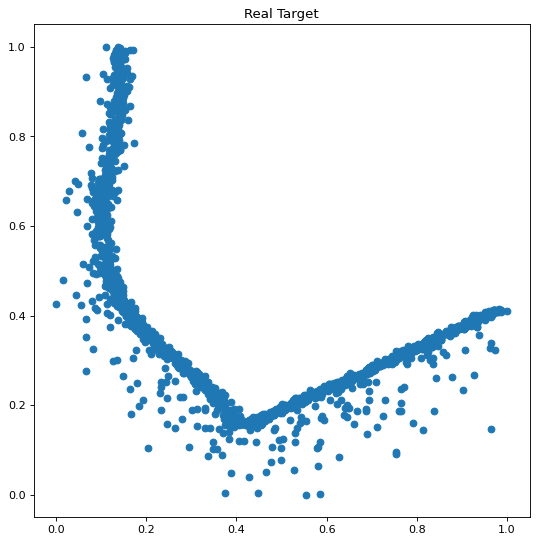

In [30]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1])
plt.title("Real Target")
#plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

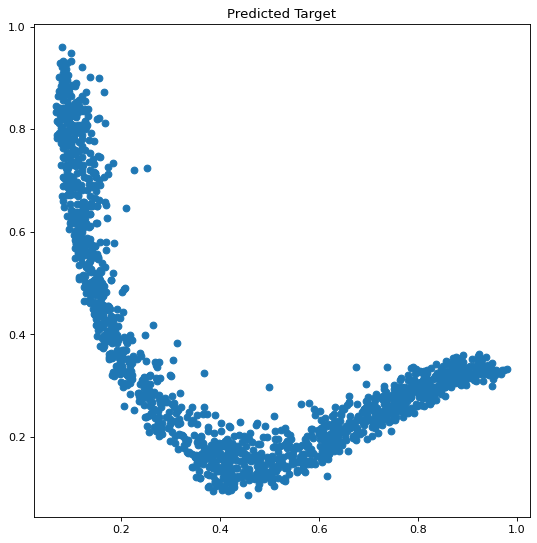

In [28]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(rbf_classifier_1.predict(x_mlcup_tr), rbf_classifier_2.predict(x_mlcup_tr))
plt.title("Predicted Target")
#plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

### Comparison between SVM and KRR

In [47]:
from sklearn.model_selection import learning_curve

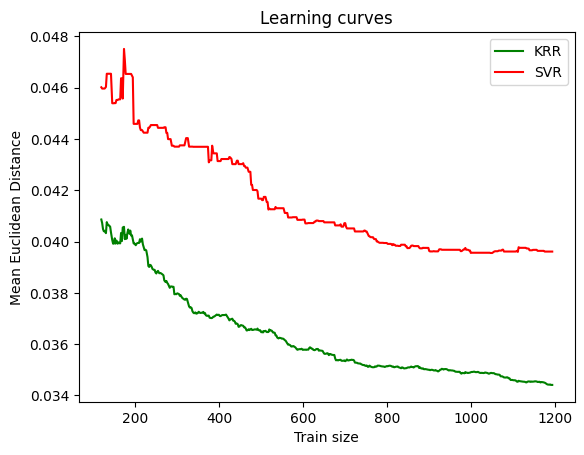

In [51]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_1.z')
kr = joblib.load('./results/ml_cup/KRR/rbf_krr_1.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

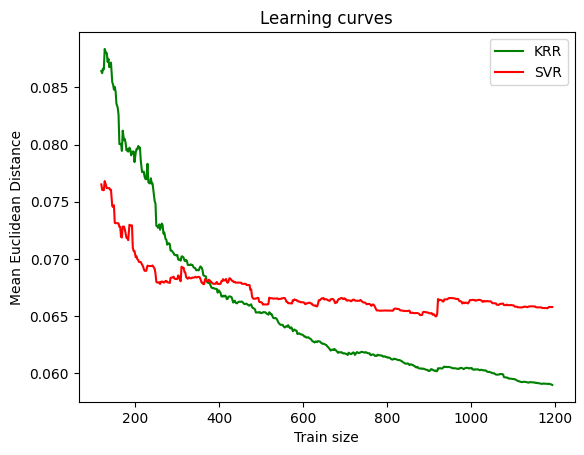

In [52]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_2.z')
kr = joblib.load('./results/ml_cup/KRR/poly_krr_2.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()